In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

In [2]:
train_data = pd.read_csv('/kaggle/input/emnist-balanced-train.csv')
test_data = pd.read_csv('/kaggle/input/emnist-balanced-test.csv')
label_map = pd.read_csv('/kaggle/input/emnist-balanced-mapping.txt', sep='\s+', header=None)

In [3]:
# create a dictionary that maps each index to its corresponding ASCII character. 
mapping_dict = {row[0]: chr(row[1]) for _, row in label_map.iterrows()}

In [4]:
# training_data
x_train = np.array(train_data.iloc[:,1:].values)
y_train = np.array(train_data.iloc[:,0].values)

# testing_data
x_test = np.array(test_data.iloc[:,1:].values)
y_test = np.array(test_data.iloc[:,0].values)

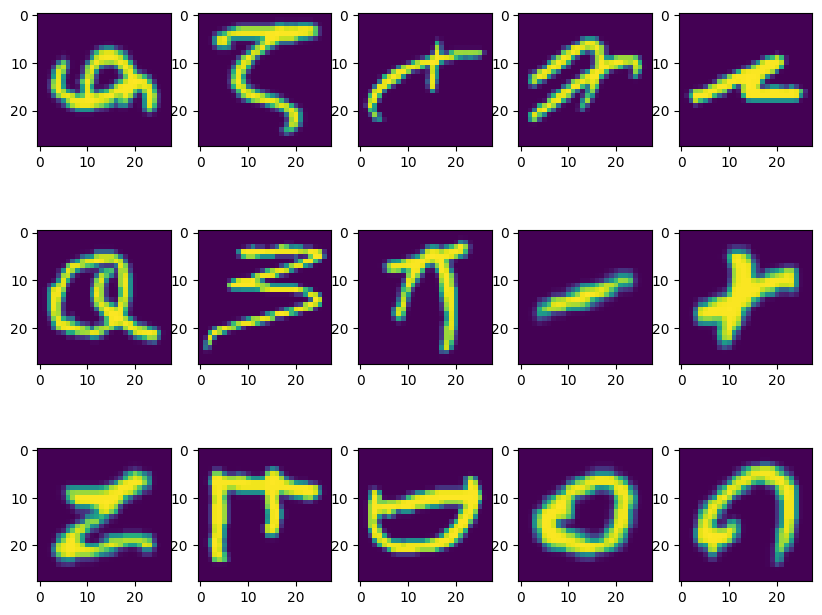

In [5]:
fig, axes = plt.subplots(3,5,figsize=(10,8))
for i,ax in enumerate(axes.flat):
    ax.imshow(x_train[i].reshape([28,28]))

In [6]:
def rotate(image):
    image = image.reshape([28, 28])
    image = np.fliplr(image)
    image = np.rot90(image)
    return image

x_train = np.apply_along_axis(rotate, 1, x_train)
x_test = np.apply_along_axis(rotate, 1, x_test)

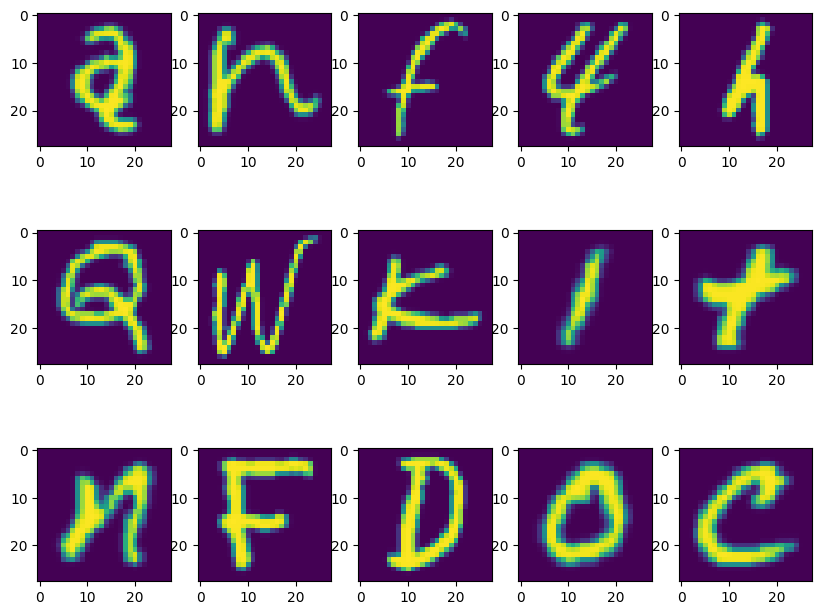

In [7]:
fig, axes = plt.subplots(3,5,figsize=(10,8))
for i,ax in enumerate(axes.flat):
    ax.imshow(x_train[i].reshape([28,28]))

In [8]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

y_train = tf.keras.utils.to_categorical(y_train, 47)
y_test = tf.keras.utils.to_categorical(y_test, 47)

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input

model = Sequential([
    Input(shape=(28, 28, 1)),
    Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(47, activation='softmax')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 12, 12, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 47)             │         6,063 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 174,959 (683.43 KB)

 Trainable params: 174,959 (683.43 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

datagen.fit(x_train)

In [12]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=3,
                               restore_best_weights=True)

In [13]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=128), 
                    epochs=20,
                    validation_data=(x_test, y_test),
                    callbacks=[early_stopping])

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1725725841.533153      63 service.cc:145] XLA service 0x7da8e00037a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725725841.533213      63 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  5/882 ━━━━━━━━━━━━━━━━━━━━ 30s 35ms/step - accuracy: 0.0475 - loss: 72.3848

I0000 00:00:1725725846.275218      63 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


882/882 ━━━━━━━━━━━━━━━━━━━━ 51s 51ms/step - accuracy: 0.1929 - loss: 5.2990 - val_accuracy: 0.7789 - val_loss: 0.6873
Epoch 2/20
882/882 ━━━━━━━━━━━━━━━━━━━━ 40s 44ms/step - accuracy: 0.6472 - loss: 1.1371 - val_accuracy: 0.8121 - val_loss: 0.5524
Epoch 3/20
882/882 ━━━━━━━━━━━━━━━━━━━━ 39s 44ms/step - accuracy: 0.7296 - loss: 0.8411 - val_accuracy: 0.8357 - val_loss: 0.4777
Epoch 4/20
882/882 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.7634 - loss: 0.7200 - val_accuracy: 0.8401 - val_loss: 0.4650
Epoch 5/20
882/882 ━━━━━━━━━━━━━━━━━━━━ 39s 44ms/step - accuracy: 0.7846 - loss: 0.6499 - val_accuracy: 0.8453 - val_loss: 0.4316
Epoch 6/20
882/882 ━━━━━━━━━━━━━━━━━━━━ 39s 44ms/step - accuracy: 0.7948 - loss: 0.6152 - val_accuracy: 0.8523 - val_loss: 0.4264
Epoch 7/20
882/882 ━━━━━━━━━━━━━━━━━━━━ 39s 44ms/step - accuracy: 0.8035 - loss: 0.5836 - val_accuracy: 0.8572 - val_loss: 0.4084
Epoch 8/20
882/882 ━━━━━━━━━━━━━━━━━━━━ 39s 44ms/step - accuracy: 0.8091 - loss: 0.5639 - val_accurac

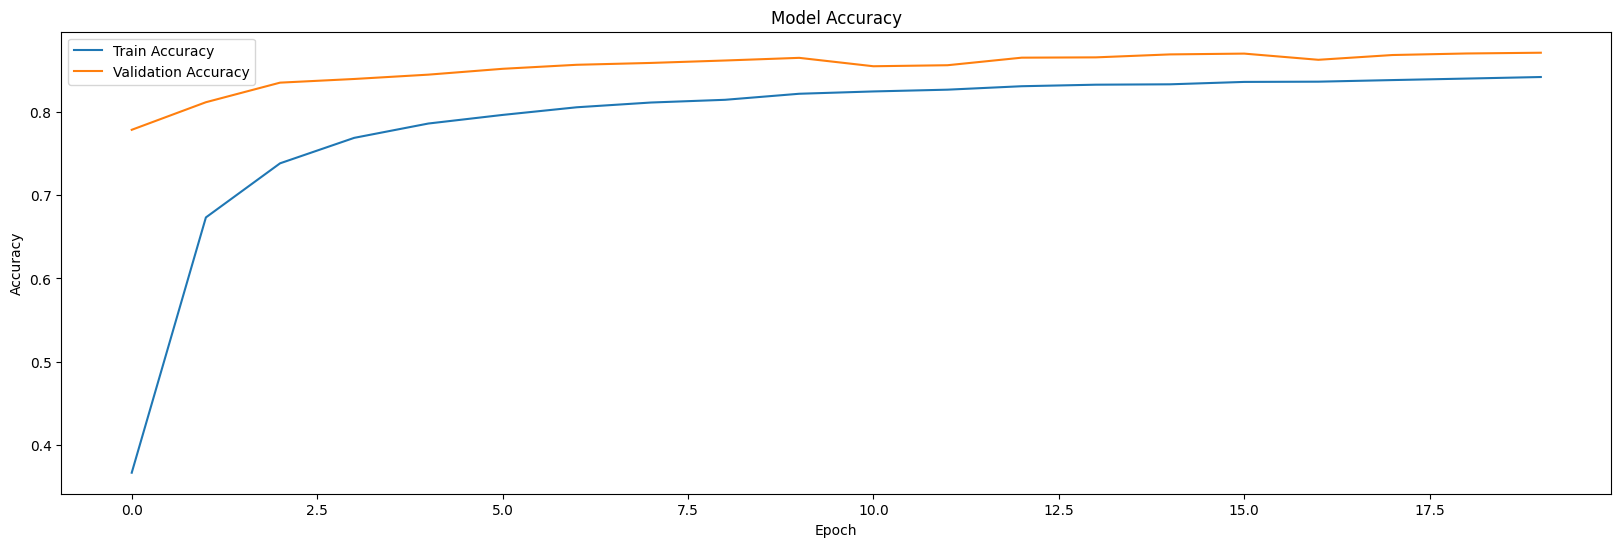

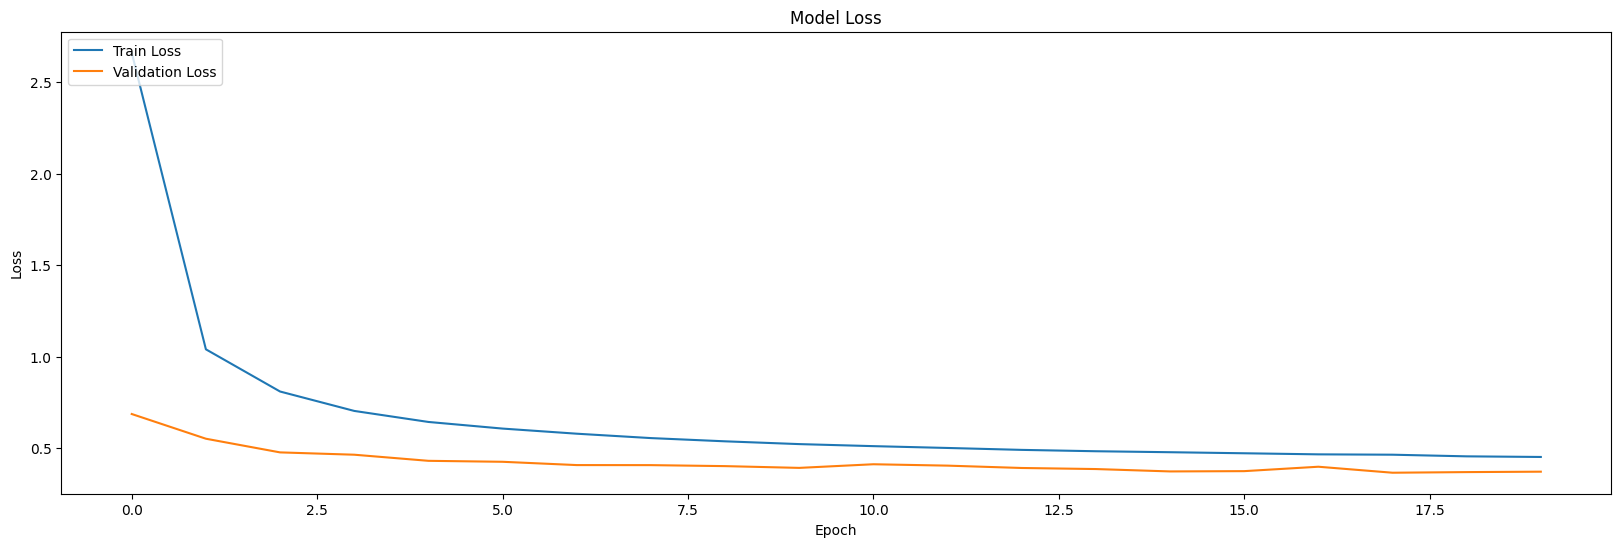

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Plot training & validation accuracy values
plt.figure(figsize=(20, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(20, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [15]:
model.save('model-v0.87.keras')

In [16]:
import tensorflow.keras.models as models
model = models.load_model('model-v0.87.keras')

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   4   4   3   3   3   4   4   4   0   0
   0   0   0   0   0   0   0   0   2   9  32  37  37  37  37  37  37  51
 114 125  95 104  95 125 127 114  45   5   0   0   0   0   0   0   4  22
  82 139 204 217 217 217 217 217 217 222 245 249 238 241 238 249 250 245
 189  32   0   0   0   0   0  32 115 172 229 245 249 250 250 250 250 250
 254 254 255 254 254 254 254 251 249 233 185  32   0   0   0   0   4 113
 241 250 192 130 127 127 127 127 134 173 253 254 251 234 233 233 204 140
 125  82  33   5   0   0   0   0   4 113 241 247 170  25   4   4   5  15
  95 211 251 232 171  85  82  80  34   9   4   2   0   0   0   0   0   0
   0  32 113 127 107  18   0   0  32 127 220 250 175  83  22   3   2   2
   0   0   0   0   0   0   0   0   0   0   0   0   4   4   3   0   1  23
 131 242 233 171  34   3   0   0   0   0   0   0   

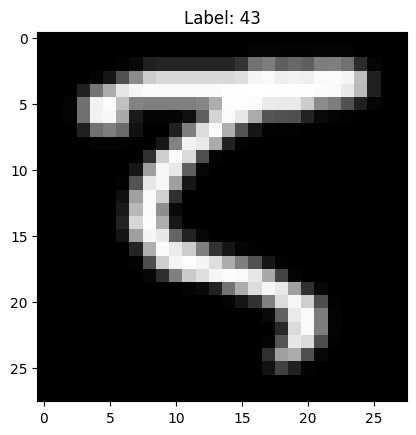

In [17]:
train_data = pd.read_csv('/kaggle/input/emnist-balanced-train.csv')

sample_index = 1
image = train_data.iloc[sample_index, 1:].values
label = train_data.iloc[sample_index, 0]

print(image)
image = image.reshape(28, 28)

plt.imshow(image, cmap='gray')
plt.title(f'Label: {label}')
plt.show()

In [18]:
def rotate(image):
    image = image.reshape([28, 28])
    image = np.fliplr(image)
    image = np.rot90(image)
    return image

image1 = rotate(image)
# image1 = image1.reshape(-1, 28, 28, 1)

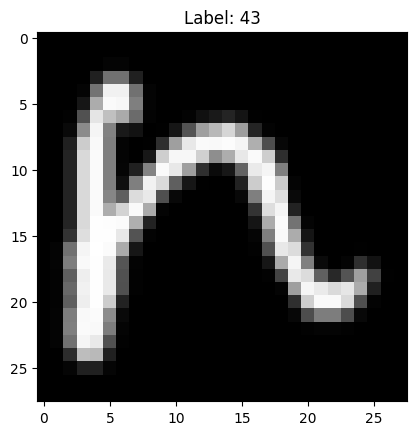

In [19]:
plt.imshow(image1, cmap='gray')
plt.title(f'Label: {label}')
plt.show()

In [20]:
image1 = image1.reshape(-1, 28, 28, 1)
print(image1)
result = model.predict(image1)

[[[[  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]]

  [[  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]]

  [[  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  4]
   [  4]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]]

  [[  0]
   [  0]
   [  0]
   [  0]
   [ 32]
   [113]
   [113]
   [ 32]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [

In [21]:
np.argmax(result)

43